In [1]:
from collections import defaultdict, namedtuple, Counter
import sys
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.misc
import statsmodels.stats as smstats
import os.path

In [30]:
phase_dir = '../../PhasingFamilies/phased_spark_wes_array_quads_del'
#phase_dir = '../../PhasingFamilies/phased_ancestry_quads'


chroms = [str(x) for x in range(1, 7)] + ['10']
#chroms = ['10']
#chroms = ['X']
#interval = 500000


In [31]:
with open('%s/info.json' % phase_dir, 'r') as f:
    data_dir = json.load(f)['data_dir']
with open('../%s/info.json' % data_dir, 'r') as f:
    build = json.load(f)['assembly']

cyto = []
with open('../data/cytoBand%s.txt' % build, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0].startswith('chr') and pieces[0][3:] in chroms:
            cyto.append((pieces[0][3:], int(pieces[1]), int(pieces[2]), pieces[3], pieces[4]))

chrom_to_start_pos = dict()
offset = 0
for chrom in chroms:
    chrom_to_start_pos[chrom] = offset
    chrom_length = max([x[2] for x in cyto if x[0]==chrom])
    offset += chrom_length

In [32]:
PValue = namedtuple('PValue', ['pvalues', 'contingency', 'regions'])
PValuePhenGroup = namedtuple('PValuePhenGroup', ['num_affected', 'mat', 'pat', 'both'])
PValueGroup = namedtuple('PValueGroup', ['chrom', 'aff_aff', 'aff_typ', 'typ_typ'])

In [33]:
def pull_pvalues(path):
    return PValue(np.load('%s.npy' % path), 
                  np.load('%s.contingency.npy' % path), 
                  np.load('%s.regions.npy' % path))
    
def pull_pvalue_phen_group(phase_dir, chrom, num_affected):
    return PValuePhenGroup(num_affected,
                               pull_pvalues('%s/chr.%s.IST.pvalues.be.aff%d.mat' % (phase_dir, chrom, num_affected)),
                               pull_pvalues('%s/chr.%s.IST.pvalues.be.aff%d.pat' % (phase_dir, chrom, num_affected)),
                               pull_pvalues('%s/chr.%s.IST.pvalues.be.aff%d.both' % (phase_dir, chrom, num_affected)))

pvaluegroups = []
for chrom in chroms:
    print(chrom)
    pvaluegroups.append(PValueGroup(chrom,
                                    pull_pvalue_phen_group(phase_dir, chrom, 2),
                                    pull_pvalue_phen_group(phase_dir, chrom, 1),
                                    pull_pvalue_phen_group(phase_dir, chrom, 0)))

1
2
3
4
5
6
10


In [34]:
print(len(pvaluegroups[0].typ_typ.both.pvalues))

1142


In [35]:
def pull_across_chroms(f):
    return np.hstack([f(p) for p in pvaluegroups])

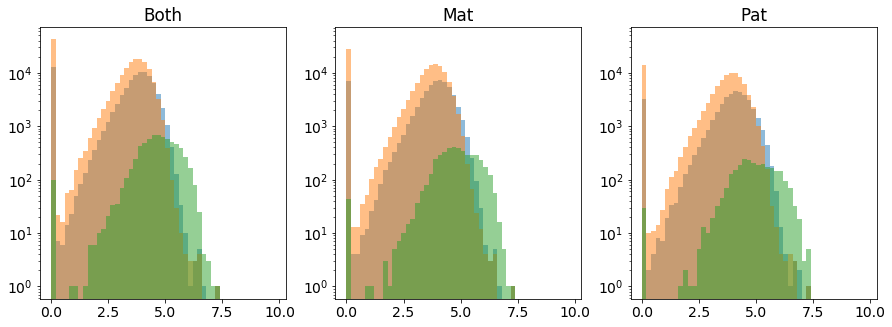

In [36]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
plt.hist(pull_across_chroms(lambda p: np.log10(p.aff_aff.both.regions[1:]-p.aff_aff.both.regions[:-1])),
         alpha=0.5, log=True, bins=np.arange(0, 10, 0.2))
plt.hist(pull_across_chroms(lambda p: np.log10(p.aff_typ.both.regions[1:]-p.aff_typ.both.regions[:-1])),
         alpha=0.5, log=True, bins=np.arange(0, 10, 0.2))
plt.hist(pull_across_chroms(lambda p: np.log10(p.typ_typ.both.regions[1:]-p.typ_typ.both.regions[:-1])),
         alpha=0.5, log=True, bins=np.arange(0, 10, 0.2))
plt.title('Both')

plt.subplot(1, 3, 2, sharey=ax)
plt.hist(pull_across_chroms(lambda p: np.log10(p.aff_aff.mat.regions[1:]-p.aff_aff.mat.regions[:-1])),
         alpha=0.5, log=True, bins=np.arange(0, 10, 0.2))
plt.hist(pull_across_chroms(lambda p: np.log10(p.aff_typ.mat.regions[1:]-p.aff_typ.mat.regions[:-1])),
         alpha=0.5, log=True, bins=np.arange(0, 10, 0.2))
plt.hist(pull_across_chroms(lambda p: np.log10(p.typ_typ.mat.regions[1:]-p.typ_typ.mat.regions[:-1])),
         alpha=0.5, log=True, bins=np.arange(0, 10, 0.2))
plt.title('Mat')

plt.subplot(1, 3, 3, sharey=ax)
plt.hist(pull_across_chroms(lambda p: np.log10(p.aff_aff.pat.regions[1:]-p.aff_aff.pat.regions[:-1])),
         alpha=0.5, log=True, bins=np.arange(0, 10, 0.2))
plt.hist(pull_across_chroms(lambda p: np.log10(p.aff_typ.pat.regions[1:]-p.aff_typ.pat.regions[:-1])),
         alpha=0.5, log=True, bins=np.arange(0, 10, 0.2))
plt.hist(pull_across_chroms(lambda p: np.log10(p.typ_typ.pat.regions[1:]-p.typ_typ.pat.regions[:-1])),
         alpha=0.5, log=True, bins=np.arange(0, 10, 0.2))
plt.title('Pat')
plt.show()

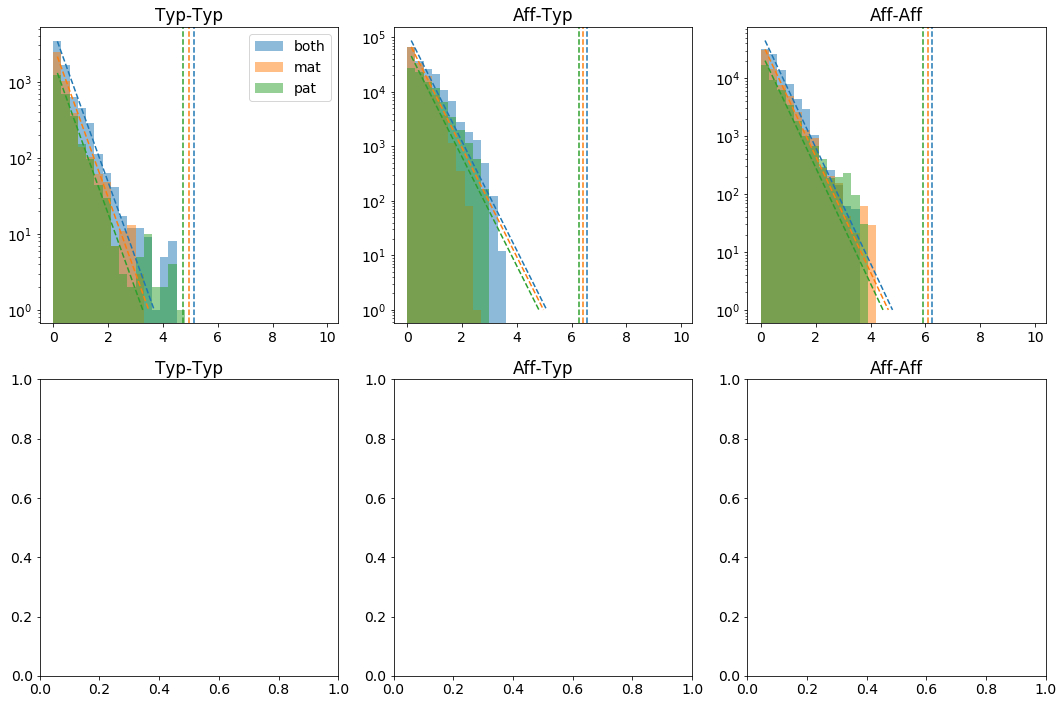

In [37]:
binsize = 0.3
plt.figure(figsize=(15, 10))

def plot_pvalue_chart(f, label, correct=False):
    n = np.sum([f(p).regions.shape[0] for p in pvaluegroups])
    pvalues = pull_across_chroms(lambda p: f(p).pvalues)
    if correct:
        reject, pvalues, _, _ = smstats.multitest.multipletests(pvalues, alpha=0.05, method='fdr_bh', is_sorted=False)
        plt.axvline(-np.log10(0.05), color='black', linestyle='--')
        plt.hist(np.clip(-np.log10(pvalues), None, 9),
                log=True, bins=np.arange(0, 10, binsize), alpha=0.5, label=label)
    else:
        bonferonni_cutoff = -np.log10(0.05/n)
        p = plt.plot([binsize/2, np.log10(n*(1-(10**-binsize))) + binsize/2], 
                     [n*(1-(10**-binsize)), 1], linestyle='--') 
        plt.axvline(bonferonni_cutoff, linestyle='--', color=p[0].get_color())
        plt.hist(np.clip(-np.log10(pvalues), None, 9),
                log=True, bins=np.arange(0, 10, binsize), alpha=0.5, label=label, color=p[0].get_color())
    

plt.subplot(2, 3, 1)
plot_pvalue_chart(lambda p: p.typ_typ.both, 'both')
plot_pvalue_chart(lambda p: p.typ_typ.mat, 'mat')
plot_pvalue_chart(lambda p: p.typ_typ.pat, 'pat')
plt.legend()
plt.title('Typ-Typ')
    
plt.subplot(2, 3, 2)
plot_pvalue_chart(lambda p: p.aff_typ.both, 'both')
plot_pvalue_chart(lambda p: p.aff_typ.mat, 'mat')
plot_pvalue_chart(lambda p: p.aff_typ.pat, 'pat')
plt.title('Aff-Typ')

plt.subplot(2, 3, 3)
plot_pvalue_chart(lambda p: p.aff_aff.both, 'both')
plot_pvalue_chart(lambda p: p.aff_aff.mat, 'mat')
plot_pvalue_chart(lambda p: p.aff_aff.pat, 'pat')
plt.title('Aff-Aff')

plt.subplot(2, 3, 4)
#plot_pvalue_chart(lambda p: p.typ_typ.both, 'both', correct=True)
#plot_pvalue_chart(lambda p: p.typ_typ.mat, 'mat', correct=True)
#plot_pvalue_chart(lambda p: p.typ_typ.pat, 'pat', correct=True)
#plt.legend()
plt.title('Typ-Typ')
    
plt.subplot(2, 3, 5)
#plot_pvalue_chart(lambda p: p.aff_typ.both, 'both', correct=True)
#plot_pvalue_chart(lambda p: p.aff_typ.mat, 'mat', correct=True)
#plot_pvalue_chart(lambda p: p.aff_typ.pat, 'pat', correct=True)
plt.title('Aff-Typ')

plt.subplot(2, 3, 6)
#plot_pvalue_chart(lambda p: p.aff_aff.both, 'both', correct=True)
#plot_pvalue_chart(lambda p: p.aff_aff.mat, 'mat', correct=True)
#plot_pvalue_chart(lambda p: p.aff_aff.pat, 'pat', correct=True)
plt.title('Aff-Aff')


plt.tight_layout()
plt.show()

No handles with labels found to put in legend.


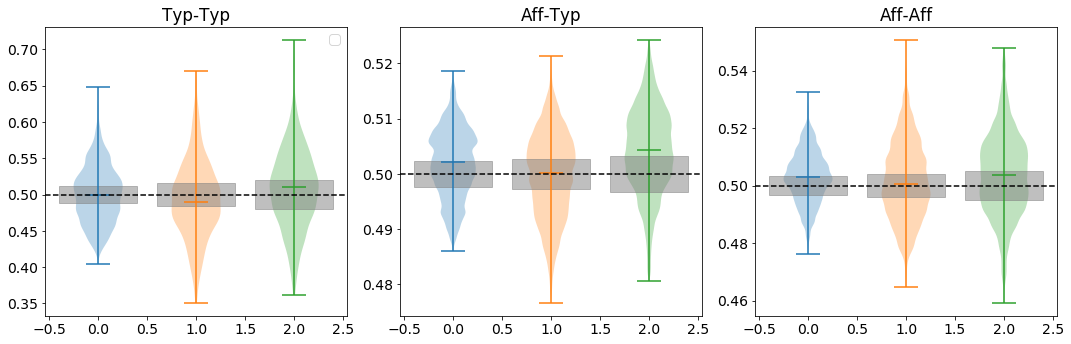

In [38]:
binsize = 0.3
plt.figure(figsize=(15, 5))

def plot_share_rate(f, label, index):
    c = pull_across_chroms(lambda p: f(p).contingency)
    n = np.max(c[1, :])
    bins = np.arange(0.4, 0.6, 0.005)
    indices = c[1, :]>(0.9*n)
    plt.violinplot([c[0, indices]/c[1, indices]], positions=[index], showmedians=True, showextrema=True)
    std = np.sqrt(0.25/np.sum(indices))
    plt.fill_between([index-0.4, index+0.4], [0.5 + 2*std, 0.5 + 2*std], [0.5 - 2*std, 0.5-2*std], alpha=0.5, color='gray')


plt.subplot(1, 3, 1)
plot_share_rate(lambda p: p.typ_typ.both, 'both', 0)
plot_share_rate(lambda p: p.typ_typ.mat, 'mat', 1)
plot_share_rate(lambda p: p.typ_typ.pat, 'pat', 2)
plt.legend()
plt.axhline(0.5, color='black', linestyle='--')
plt.title('Typ-Typ')
    
plt.subplot(1, 3, 2)
plot_share_rate(lambda p: p.aff_typ.both, 'both', 0)
plot_share_rate(lambda p: p.aff_typ.mat, 'mat', 1)
plot_share_rate(lambda p: p.aff_typ.pat, 'pat', 2)
plt.axhline(0.5, color='black', linestyle='--')
plt.title('Aff-Typ')

plt.subplot(1, 3, 3)
plot_share_rate(lambda p: p.aff_aff.both, 'both', 0)
plot_share_rate(lambda p: p.aff_aff.mat, 'mat', 1)
plot_share_rate(lambda p: p.aff_aff.pat, 'pat', 2)
plt.axhline(0.5, color='black', linestyle='--')
plt.title('Aff-Aff')

plt.tight_layout()
plt.show()

autism-autism
neurotypical-autism
neurotypical-neurotypical
autism-autism
neurotypical-autism
neurotypical-neurotypical
autism-autism
neurotypical-autism
neurotypical-neurotypical


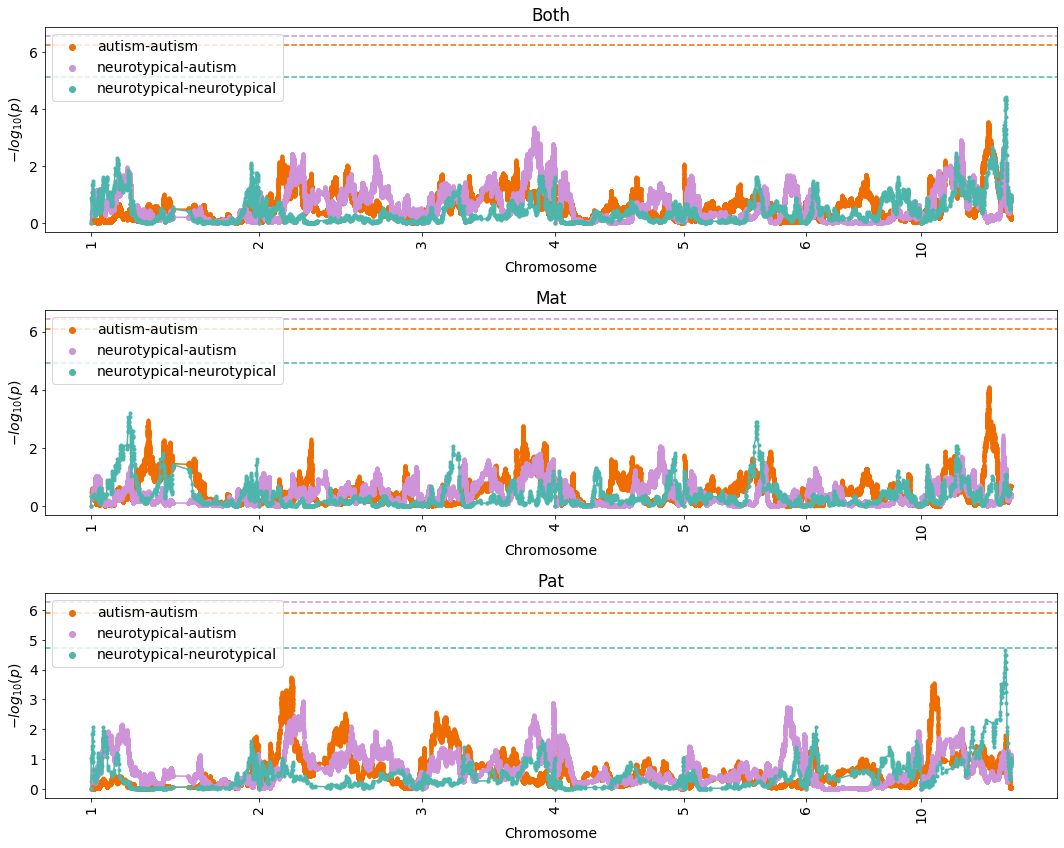

In [39]:
import matplotlib
plt.figure(figsize=(15, 12))
matplotlib.rcParams.update({'font.size': 14})

def plot_and_highlight_sig(f, label, color):
    print(label)
    xs = pull_across_chroms(lambda p: f(p).regions[:-1]+chrom_to_start_pos[p.chrom])
    cs = pull_across_chroms(lambda p: chroms.index(p.chrom)*np.ones((f(p).regions[:-1].shape[0]), dtype=int))
    ps = pull_across_chroms(lambda p: np.vstack((f(p).regions[:-1], f(p).regions[1:])))
    pvalues = pull_across_chroms(lambda p: np.clip(-np.log10(f(p).pvalues), 0, 10))
    
    bonferonni_cutoff = -np.log10(0.05/xs.shape[0])
    plt.plot(xs, pvalues, marker='.', color=color)
    indices = pvalues>bonferonni_cutoff
    plt.scatter(xs[indices], pvalues[indices], label=label, color=color)
    plt.axhline(bonferonni_cutoff, color=color, linestyle='--')
    
    # print significant regions
    start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0], np.where(indices[:-1] & ~indices[1:])[0]+1
    for start_index, end_index in zip(start_indices, end_indices):
        print('%s:%d-%d (hg%s)' % (chroms[cs[start_index]], ps[0, start_index], ps[1, end_index], build))


plt.subplot(3, 1, 1)
plot_and_highlight_sig(lambda p: p.aff_aff.both, 'autism-autism', '#ef6c00ff')
plot_and_highlight_sig(lambda p: p.aff_typ.both, 'neurotypical-autism', '#ce93d8ff')
plot_and_highlight_sig(lambda p: p.typ_typ.both, 'neurotypical-neurotypical', '#4db6acff')

plt.xticks([chrom_to_start_pos[chrom] for chrom in chroms], chroms, rotation=90)
plt.legend(loc='upper left')
plt.xlabel('Chromosome')
plt.ylabel('$-log_{10}(p)$')
plt.title('Both')

plt.subplot(3, 1, 2)
plot_and_highlight_sig(lambda p: p.aff_aff.mat, 'autism-autism', '#ef6c00ff')
plot_and_highlight_sig(lambda p: p.aff_typ.mat, 'neurotypical-autism', '#ce93d8ff')
plot_and_highlight_sig(lambda p: p.typ_typ.mat, 'neurotypical-neurotypical', '#4db6acff')

plt.xticks([chrom_to_start_pos[chrom] for chrom in chroms], chroms, rotation=90)
plt.legend(loc='upper left')
plt.xlabel('Chromosome')
plt.ylabel('$-log_{10}(p)$')
plt.title('Mat')

plt.subplot(3, 1, 3)
plot_and_highlight_sig(lambda p: p.aff_aff.pat, 'autism-autism', '#ef6c00ff')
plot_and_highlight_sig(lambda p: p.aff_typ.pat, 'neurotypical-autism', '#ce93d8ff')
plot_and_highlight_sig(lambda p: p.typ_typ.pat, 'neurotypical-neurotypical', '#4db6acff')

plt.xticks([chrom_to_start_pos[chrom] for chrom in chroms], chroms, rotation=90)
plt.legend(loc='upper left')
plt.xlabel('Chromosome')
plt.ylabel('$-log_{10}(p)$')
plt.title('Pat')
plt.tight_layout()
plt.show()

In [40]:
xs = pvaluegroups[0].typ_typ.both.regions[:-1]
print(pvaluegroups[0].typ_typ.both.pvalues[(xs>=127188569) & (xs<=128188569)])

[]


autism-autism


AttributeError: module 'statsmodels.stats' has no attribute 'multitest'

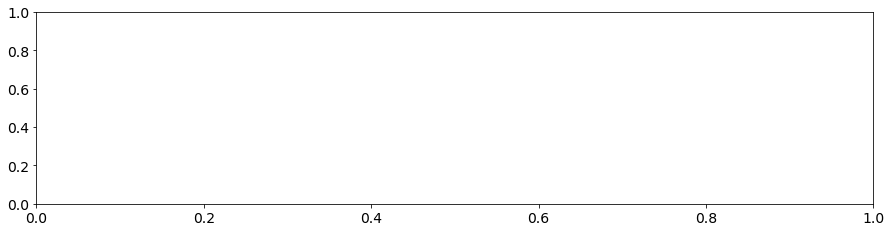

In [41]:
import matplotlib
plt.figure(figsize=(15, 12))
matplotlib.rcParams.update({'font.size': 14})

def plot_and_highlight_sig(f, label, color):
    print(label)
    xs = pull_across_chroms(lambda p: f(p).regions[:-1]+chrom_to_start_pos[p.chrom])
    cs = pull_across_chroms(lambda p: chroms.index(p.chrom)*np.ones((f(p).regions[:-1].shape[0]), dtype=int))
    ps = pull_across_chroms(lambda p: np.vstack((f(p).regions[:-1], f(p).regions[1:])))
    pvalues = pull_across_chroms(lambda p: f(p).pvalues)
    
    reject, pvalues, _, _ = smstats.multitest.multipletests(pvalues, alpha=0.05, method='fdr_bh', is_sorted=False)
    pvalues = np.clip(-np.log10(pvalues), 0, 10)
    
    bonferonni_cutoff = -np.log10(0.05)
    plt.plot(xs, pvalues, marker='.', color=color)
    indices = pvalues>bonferonni_cutoff
    plt.scatter(xs[indices], pvalues[indices], label=label, color=color)
    plt.axhline(bonferonni_cutoff, color=color, linestyle='--')
    
    # print significant regions
    start_index, run = None, None
    for index in np.where(indices)[0]:
        if start_index is None:
            start_index, run = index, 0
        elif start_index+run+1 == index:
            run += 1
        else:
            print('%s:%d-%d (hg%s)' % (chroms[cs[start_index]], ps[0, start_index], ps[1, start_index+run], build))
            start_index, run = index, 0
    if start_index is not None:
        print('%s:%d-%d (hg%s)' % (chroms[cs[start_index]], ps[0, start_index], ps[1, start_index+run], build))



plt.subplot(3, 1, 1)
plot_and_highlight_sig(lambda p: p.aff_aff.both, 'autism-autism', '#ef6c00ff')
plot_and_highlight_sig(lambda p: p.aff_typ.both, 'neurotypical-autism', '#ce93d8ff')
plot_and_highlight_sig(lambda p: p.typ_typ.both, 'neurotypical-neurotypical', '#4db6acff')

plt.xticks([chrom_to_start_pos[chrom] for chrom in chroms], chroms, rotation=90)
plt.legend(loc='upper left')
plt.xlabel('Chromosome')
plt.ylabel('$-log_{10}(p)$')
plt.title('Both')

plt.subplot(3, 1, 2)
plot_and_highlight_sig(lambda p: p.aff_aff.mat, 'autism-autism', '#ef6c00ff')
plot_and_highlight_sig(lambda p: p.aff_typ.mat, 'neurotypical-autism', '#ce93d8ff')
plot_and_highlight_sig(lambda p: p.typ_typ.mat, 'neurotypical-neurotypical', '#4db6acff')

plt.xticks([chrom_to_start_pos[chrom] for chrom in chroms], chroms, rotation=90)
plt.legend(loc='upper left')
plt.xlabel('Chromosome')
plt.ylabel('$-log_{10}(p)$')
plt.title('Mat')

plt.subplot(3, 1, 3)
plot_and_highlight_sig(lambda p: p.aff_aff.pat, 'autism-autism', '#ef6c00ff')
plot_and_highlight_sig(lambda p: p.aff_typ.pat, 'neurotypical-autism', '#ce93d8ff')
plot_and_highlight_sig(lambda p: p.typ_typ.pat, 'neurotypical-neurotypical', '#4db6acff')

plt.xticks([chrom_to_start_pos[chrom] for chrom in chroms], chroms, rotation=90)
plt.legend(loc='upper left')
plt.xlabel('Chromosome')
plt.ylabel('$-log_{10}(p)$')
plt.title('Pat')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib

chrom = '14'
chrom_index = chroms.index(chrom)

def plot_and_highlight_sig(f, label, color):
    print(label)
    xs = f(pvaluegroups[chrom_index]).regions
    pvalues = np.clip(-np.log10(f(pvaluegroups[chrom_index]).pvalues), 0, 10)
    
    bonferonni_cutoff = -np.log10(0.05/xs.shape[0])
    plt.plot(xs[:-1], pvalues, marker='.', color=color)
    indices = pvalues>bonferonni_cutoff
    plt.scatter(xs[:-1][indices], pvalues[indices], label=label, color=color)
    plt.axhline(bonferonni_cutoff, color=color, linestyle='--')
    
    # print significant regions
    start_indices, end_indices = np.where(~indices[:-1] & indices[1:])[0], np.where(indices[:-1] & ~indices[1:])[0]+1
    for start_index, end_index in zip(start_indices, end_indices):
        print('%s:%d-%d (hg%s)' % (chrom, xs[start_index], xs[end_index+1], build))





plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
plot_and_highlight_sig(lambda p: p.aff_aff.both, 'autism-autism', '#ef6c00ff')
plot_and_highlight_sig(lambda p: p.aff_typ.both, 'neurotypical-autism', '#ce93d8ff')
plot_and_highlight_sig(lambda p: p.typ_typ.both, 'neurotypical-neurotypical', '#4db6acff')

plt.xticks([x[1] for x in cyto if x[0]==chrom], [x[3] for x in cyto if x[0]==chrom], rotation=90)
plt.legend(loc='upper left')
plt.xlabel('Chromosome')
plt.ylabel('$-log_{10}(p)$')
plt.title('Both')

plt.subplot(3, 1, 2)
plot_and_highlight_sig(lambda p: p.aff_aff.mat, 'autism-autism', '#ef6c00ff')
plot_and_highlight_sig(lambda p: p.aff_typ.mat, 'neurotypical-autism', '#ce93d8ff')
plot_and_highlight_sig(lambda p: p.typ_typ.mat, 'neurotypical-neurotypical', '#4db6acff')

plt.xticks([x[1] for x in cyto if x[0]==chrom], [x[3] for x in cyto if x[0]==chrom], rotation=90)
plt.legend(loc='upper left')
plt.xlabel('Chromosome')
plt.ylabel('$-log_{10}(p)$')
plt.title('Mat')

plt.subplot(3, 1, 3)
plot_and_highlight_sig(lambda p: p.aff_aff.pat, 'autism-autism', '#ef6c00ff')
plot_and_highlight_sig(lambda p: p.aff_typ.pat, 'neurotypical-autism', '#ce93d8ff')
plot_and_highlight_sig(lambda p: p.typ_typ.pat, 'neurotypical-neurotypical', '#4db6acff')

plt.xticks([x[1] for x in cyto if x[0]==chrom], [x[3] for x in cyto if x[0]==chrom], rotation=90)
plt.legend(loc='upper left')
plt.xlabel('Chromosome')
plt.ylabel('$-log_{10}(p)$')
plt.title('Pat')

plt.tight_layout()
plt.show()

In [ ]:
if build == '37':
    start_pos, end_pos = 127188569, 128188569
elif build == '38':
    start_pos, end_pos = 125500000, 126500000

regions_of_interest = np.where((all_chroms==9) & (np.minimum(all_regions[:, 1], end_pos)-np.maximum(all_regions[:, 0], start_pos)>0))[0]
region_of_interest = regions_of_interest[0]
print(regions_of_interest)
print(pvalues[regions_of_interest, :])
print((np.minimum(all_regions[:, 1], end_pos)-np.maximum(all_regions[:, 0], start_pos))[regions_of_interest])
print(contingency[region_of_interest, 0, :])
print(contingency[region_of_interest, 0, 0]/contingency[region_of_interest, 0, 1])


In [ ]:
n = contingency[region_of_interest, 0, 1]
p_hat = contingency[region_of_interest, 0, 0]/n
z = 1.96
wilson_lower_conf = (2*n*p_hat + z**2 - (z*np.sqrt(z**2 - (1/n) + 4*n*p_hat*(1-p_hat) + (4*p_hat - 2)) + 1))/(2*(n+z**2))
wilson_upper_conf = (2*n*p_hat + z**2 + (z*np.sqrt(z**2 - (1/n) + 4*n*p_hat*(1-p_hat) + (4*p_hat - 2)) + 1))/(2*(n+z**2))
print(p_hat, wilson_lower_conf, wilson_upper_conf)

# from spark
p_hat, wilson_lower_conf, wilson_upper_conf = 0.6807228915662651, 0.6032887469766876, 0.7499815943295649
print(p_hat, wilson_lower_conf, wilson_upper_conf)

NameError: name 'p_hat' is not defined

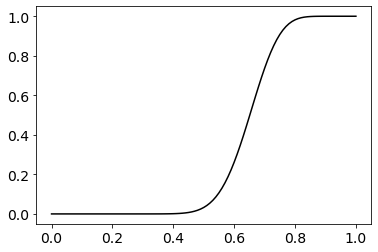

In [16]:
# power calculation
# null hypothesis is that p=0.5
# one-sided test

n = 18*2
alpha = 0.05
p = np.arange(0, 1.01, 0.01)

cutoffs = np.arange(0, n+1)
cdf = stats.binom.cdf(cutoffs, n, 0.5)
cutoff = cutoffs[np.argmax(cdf>=(1-alpha))]

#plt.figure(figsize=(15, 5))
#plt.subplot(1, 2, 1)
#plt.plot(cdf)
#plt.axvline(cutoff, color='black')
#print(cutoff)

#plt.subplot(1, 2, 2)
ps = np.arange(0, 1.01, 0.01)
power = 1-stats.binom.cdf(cutoff, n, ps)
plt.plot(ps, power, color='black', label='n=18')

plt.axvline(p_hat, color=colors[0], label='SPARK estimate')
plt.axvspan(wilson_lower_conf, wilson_upper_conf, alpha=0.5, color=colors[0])
plt.xlabel('P[IBD]')
plt.ylabel('Power')
#plt.legend()

plt.show()

#print(stats.binom.(0.5, ))

In [17]:
print(power[np.searchsorted(ps, p_hat)])


NameError: name 'p_hat' is not defined